This ipynb is done for interpretation of  the Bayesian model results to answer the research question: **"Does in-game serve performance reliably predict point outcomes?"**

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.special import expit
import pickle
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent 
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
trace_path = RESULTS_DIR / 'trace_final_v2.nc'
trace = az.from_netcdf(trace_path)

# 2. Load Features (Context)
feature_path = PROCESSED_DIR / 'features_match_1501.pkl'
features_df = pd.read_pickle(feature_path)

# Since we trained on scaled data (Z-scores), we need these standard deviations
# to translate our "What If" scenarios back into the model's units.
std_srv = features_df['srv_pct'].std()
std_ace = features_df['ace_rate'].std()
print(f"Scaling Factors loaded: Srv_Std={std_srv:.3f}, Ace_Std={std_ace:.3f}")

# 3. Load Priors (Reference)
with open(PROCESSED_DIR / 'priors_2023.pkl', 'rb') as f:
    priors = pickle.load(f)

Scaling Factors loaded: Srv_Std=0.054, Ace_Std=0.021



##  Posterior Distributions (The "Answer")

We visualize the posterior distributions for the key parameters.

  * **Intercept ($\alpha$)**: The "Base Skill" of each player.
  * **Serve Impact ($\beta_{srv}$)**: The marginal benefit of a better serve.
  * **Ace Impact ($\beta_{ace}$)**: The marginal benefit of hitting aces.

If the distributions for $\beta$ are entirely positive (clear of 0), we have strong evidence that the technical stat matters.


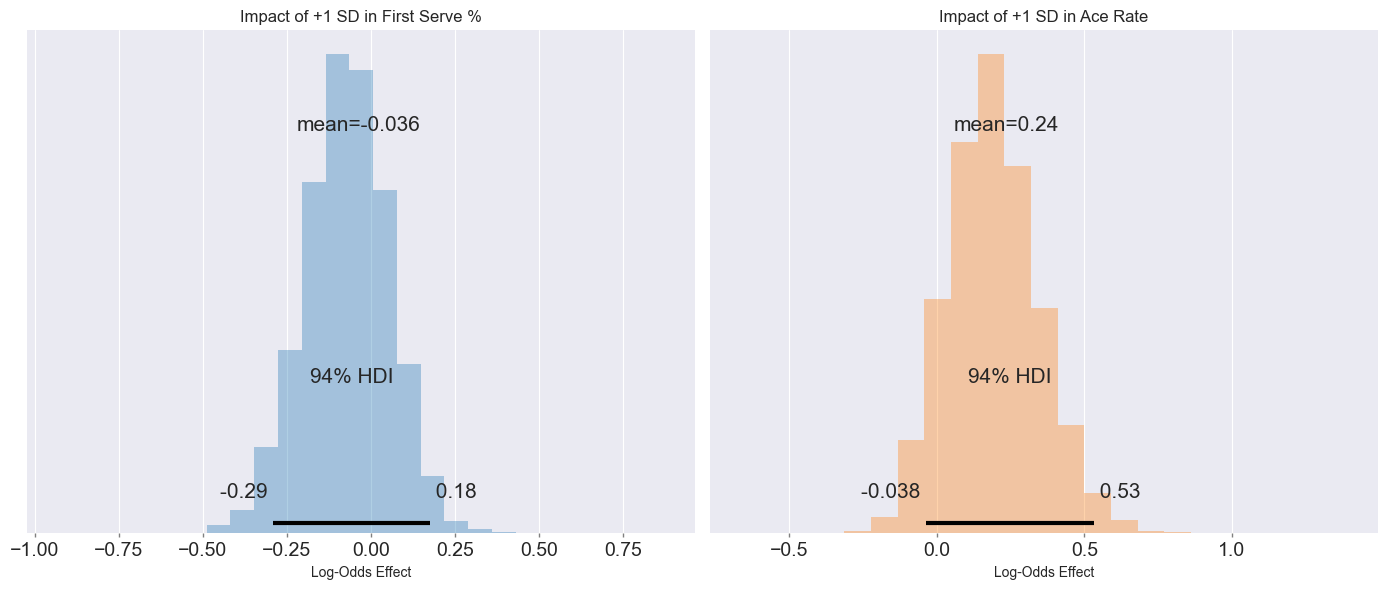

In [3]:
# Extract Posterior Samples
posterior = trace.posterior

# Flatten samples for calculation
beta_srv_samples = posterior['beta_srv'].values.flatten()
beta_ace_samples = posterior['beta_ace'].values.flatten()

# Note: We use isel to select the specific player dimension
alpha_p1_samples = posterior['alpha_player'].isel(player=0).values.flatten()
alpha_p2_samples = posterior['alpha_player'].isel(player=1).values.flatten()

# Plot Posterior Densities
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Beta Serve (First Serve Impact)
az.plot_posterior(
    trace, 
    var_names=['beta_srv'], 
    hdi_prob=0.94, 
    kind='hist',
    ax=axes[0],
    color='tab:blue'
)
axes[0].set_title(f"Impact of +1 SD in First Serve %")
axes[0].set_xlabel("Log-Odds Effect")

# Beta Ace (Ace Rate Impact)
az.plot_posterior(
    trace, 
    var_names=['beta_ace'], 
    hdi_prob=0.94, 
    kind='hist',
    ax=axes[1],
    color='tab:orange'
)
axes[1].set_title(f"Impact of +1 SD in Ace Rate")
axes[1].set_xlabel("Log-Odds Effect")

plt.tight_layout()
plt.show()

##  "What If?" Scenario Analysis

Log-odds are hard to interpret. We translate them into **Win Probabilities**.

**Scenario:**
Imagine both players are performing exactly at their historical average ($\text{deviation} = 0$).

  * What is the probability Sinner wins a point?
  * What is the probability Medvedev wins a point?

Now, what if Sinner improves his First Serve % by **+10%** (deviation = +0.10)? How much does his win probability increase?

In [4]:
print("\n" + "="*60)
print(" SCENARIO ANALYSIS (Scaled Correctly)")
print("="*60)

def calculate_win_prob(alpha_samples, beta_samples, raw_deviation, scaling_factor):
    """
    Calculate win probability distribution for a given technical deviation.
    We divide raw_deviation by the scaling_factor (Std Dev) to match the model's Z-score training.
    """
    # Convert raw percentage (e.g. 0.10) to Z-score (e.g. 0.8 stds)
    z_score = raw_deviation / scaling_factor
    
    logits = alpha_samples + (beta_samples * z_score)
    probs = expit(logits) # Inverse logit
    return probs

# BASELINE (Deviation = 0)
p1_base = calculate_win_prob(alpha_p1_samples, beta_srv_samples, 0, std_srv)
print(f"Baseline Win Probability (P1): {p1_base.mean():.1%}")

# SCENARIO A: CONSISTENCY (+10% First Serves)
p1_safe = calculate_win_prob(alpha_p1_samples, beta_srv_samples, 0.10, std_srv)
gain_safe = p1_safe - p1_base

print(f"\nScenario A (+10% First Serve):")
print(f"  New Win Prob:  {p1_safe.mean():.1%}")
print(f"  Marginal Gain: {gain_safe.mean():+.1%} points")

# SCENARIO B: AGGRESSION (+5% Aces)
p1_aggr = calculate_win_prob(alpha_p1_samples, beta_ace_samples, 0.05, std_ace)
gain_aggr = p1_aggr - p1_base

print(f"\nScenario B (+5% Aces):")
print(f"  New Win Prob:  {p1_aggr.mean():.1%}")
print(f"  Marginal Gain: {gain_aggr.mean():+.1%} points")

if gain_aggr.mean() > gain_safe.mean():
    print("\nCONCLUSION: Aggression (Aces) provides higher value per unit of effort.")
else:
    print("\nCONCLUSION: Consistency (First Serve) is the safer strategy.")


 SCENARIO ANALYSIS (Scaled Correctly)
Baseline Win Probability (P1): 70.3%

Scenario A (+10% First Serve):
  New Win Prob:  68.7%
  Marginal Gain: -1.6% points

Scenario B (+5% Aces):
  New Win Prob:  80.1%
  Marginal Gain: +9.8% points

CONCLUSION: Aggression (Aces) provides higher value per unit of effort.


## Visualizing The "Skill Curve"

This plot summarizes the entire model. It shows how the **probability of winning a point** changes as serve performance deviates from the average.

  * **X-Axis**: Deviation from Historical Serve % (e.g., -10% to +10%).
  * **Y-Axis**: Probability of Winning the Point.
  * **Shaded Bands**: 94% HDI (Uncertainty).

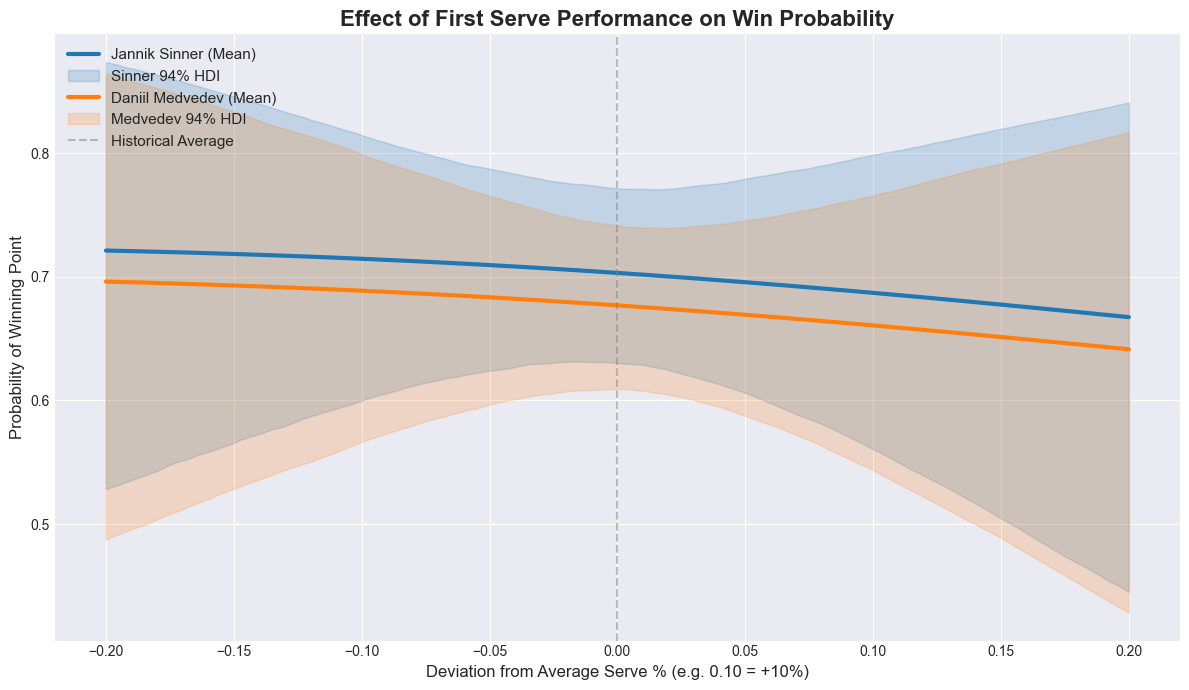

In [5]:
# Define grid: -20% to +20% deviation
x_dev_raw = np.linspace(-0.20, 0.20, 100)

# Scale the grid for the model (divide by Std Dev)
x_dev_scaled = x_dev_raw / std_srv

# Calculate probabilities
p1_probs = np.array([expit(alpha_p1_samples + beta_srv_samples * x) for x in x_dev_scaled])
p2_probs = np.array([expit(alpha_p2_samples + beta_srv_samples * x) for x in x_dev_scaled])

# Calculate Mean and 94% HDI
p1_mean = p1_probs.mean(axis=1)
p1_hdi = np.percentile(p1_probs, [3, 97], axis=1)

p2_mean = p2_probs.mean(axis=1)
p2_hdi = np.percentile(p2_probs, [3, 97], axis=1)

fig, ax = plt.subplots(figsize=(12, 7))

# Player 1 (Blue)
ax.plot(x_dev_raw, p1_mean, color='tab:blue', linewidth=3, label='Jannik Sinner (Mean)')
ax.fill_between(x_dev_raw, p1_hdi[0], p1_hdi[1], color='tab:blue', alpha=0.2, label='Sinner 94% HDI')

# Player 2 (Orange)
ax.plot(x_dev_raw, p2_mean, color='tab:orange', linewidth=3, label='Daniil Medvedev (Mean)')
ax.fill_between(x_dev_raw, p2_hdi[0], p2_hdi[1], color='tab:orange', alpha=0.2, label='Medvedev 94% HDI')

ax.axvline(0, color='gray', linestyle='--', alpha=0.5, label='Historical Average')
ax.set_title("Effect of First Serve Performance on Win Probability", fontsize=16, fontweight='bold')
ax.set_xlabel("Deviation from Average Serve % (e.g. 0.10 = +10%)", fontsize=12)
ax.set_ylabel("Probability of Winning Point", fontsize=12)
ax.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()


## Convergence and Stability Analysis

To validate our findings, we track how the model's beliefs evolved as it observed more data points (from 10 points up to the full match).

  * **Stability:** Did the coefficients settle on a stable value?
  * **Learning:** Did the uncertainty (shaded region) decrease over time?

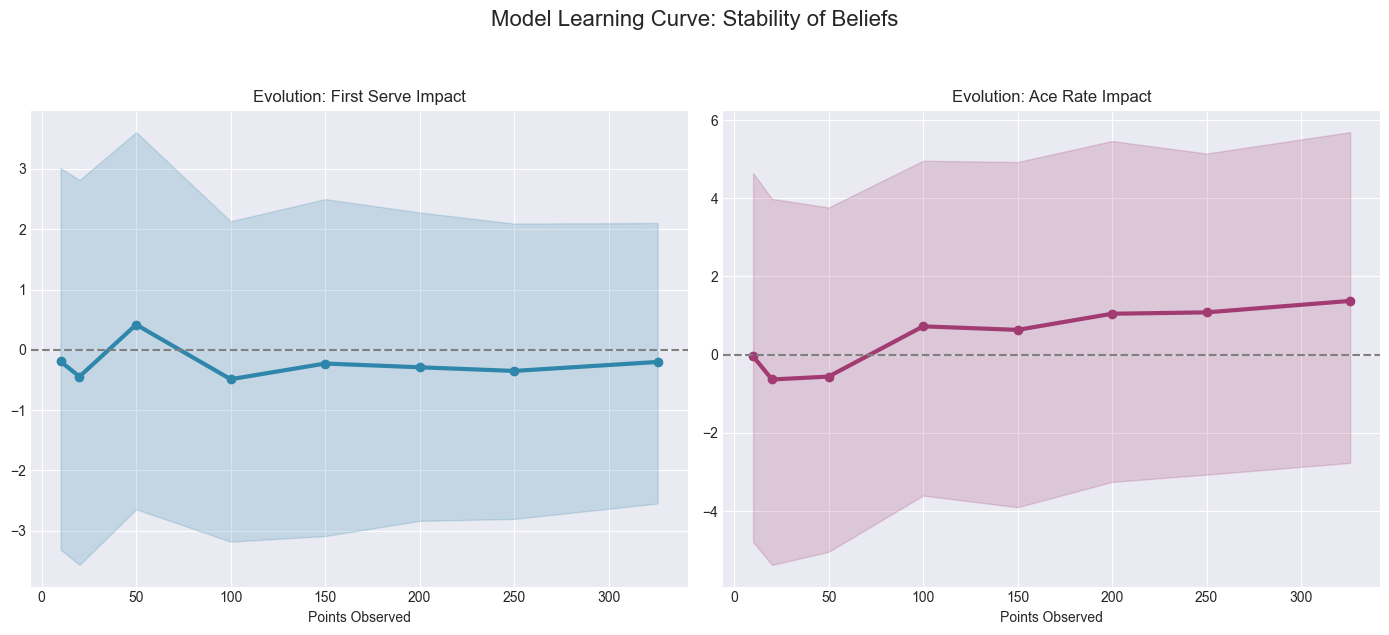

In [ ]:
evolution_path = RESULTS_DIR / 'coefficient_evolution.pkl'

with open(evolution_path, 'rb') as f:
    evo_data = pickle.load(f)

windows = evo_data['windows']
beta_srv = evo_data['beta_srv']
beta_ace = evo_data['beta_ace']

# Helper to extract stats
def get_evo_arrays(data_list):
    means = [x['mean'] for x in data_list]
    q5 = [x['q5'] for x in data_list]
    q95 = [x['q95'] for x in data_list]
    return means, q5, q95

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. First Serve Impact
s_means, s_q5, s_q95 = get_evo_arrays(beta_srv)
axes[0].plot(windows, s_means, marker='o', linewidth=3, color='#2E86AB', label='Mean Estimate')
axes[0].fill_between(windows, s_q5, s_q95, color='#2E86AB', alpha=0.2, label='90% Uncertainty')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].set_title("Evolution: First Serve Impact")
axes[0].set_xlabel("Points Observed")

# 2. Ace Rate Impact
a_means, a_q5, a_q95 = get_evo_arrays(beta_ace)
axes[1].plot(windows, a_means, marker='o', linewidth=3, color='#A23B72', label='Mean Estimate')
axes[1].fill_between(windows, a_q5, a_q95, color='#A23B72', alpha=0.2, label='90% Uncertainty')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_title("Evolution: Ace Rate Impact")
axes[1].set_xlabel("Points Observed")

plt.suptitle("Model Learning Curve: Stability of Beliefs", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()/